In [2]:
import pandas as pd
import polars as pl
import json
import os
from tqdm import tqdm
import shutil
from matplotlib import pyplot as plt

In [3]:
pred_df = pl.scan_csv('../outputs/external_labeling/tmp_csv/ensemble_r101_x3d_convnexttiny2d_part0.csv').collect()
pred_df

shape: (1_533, 5)
┌──────────────────┬─────────┬─────────┬─────────┬───────────┐
│ tomo_id          ┆ motor_z ┆ motor_y ┆ motor_x ┆ conf      │
│ ---              ┆ ---     ┆ ---     ┆ ---     ┆ ---       │
│ str              ┆ f64     ┆ f64     ┆ f64     ┆ f64       │
╞══════════════════╪═════════╪═════════╪═════════╪═══════════╡
│ aba2013-04-06-13 ┆ 265.5   ┆ 597.5   ┆ 281.5   ┆ 0.477051  │
│ aba2013-04-06-10 ┆ 281.5   ┆ 229.5   ┆ 445.5   ┆ 0.612793  │
│ aba2013-04-06-16 ┆ 277.5   ┆ 201.5   ┆ 393.5   ┆ 0.558594  │
│ aba2013-04-06-18 ┆ 281.5   ┆ 193.5   ┆ 309.5   ┆ 0.5234375 │
│ aba2013-04-06-15 ┆ 297.5   ┆ 105.5   ┆ 497.5   ┆ 0.589355  │
│ …                ┆ …       ┆ …       ┆ …       ┆ …         │
│ ycw2013-11-24-5  ┆ 406.5   ┆ 117.875 ┆ 588.0   ┆ 0.479248  │
│ ycw2013-11-24-5  ┆ 426.0   ┆ 289.75  ┆ 815.0   ┆ 0.390625  │
│ ycw2013-11-24-5  ┆ 439.0   ┆ 319.0   ┆ 841.0   ┆ 0.241821  │
│ ycw2017-11-30-30 ┆ 354.25  ┆ 275.0   ┆ 628.0   ┆ 0.357666  │
│ ycw2017-11-30-30 ┆ 354.25  ┆ 227.375 ┆ 632.0   ┆ 0.245972  │
└──────────────────┴─────────┴─────────┴─────────┴───────────┘

In [4]:
pred_df.group_by('tomo_id').len('num_motors').group_by('num_motors').len().sort('num_motors')

shape: (4, 2)
┌────────────┬──────┐
│ num_motors ┆ len  │
│ ---        ┆ ---  │
│ u32        ┆ u32  │
╞════════════╪══════╡
│ 1          ┆ 1100 │
│ 2          ┆ 144  │
│ 3          ┆ 27   │
│ 4          ┆ 16   │
└────────────┴──────┘

In [5]:
gt_df = pl.scan_csv('/home/dangnh36/datasets/.comp/byu/external/external_labels_v1.csv').select('tomo_id', 'motor_z', 'motor_y', 'motor_x', 'target_spacing', 'target_shape').collect()
gt_df

shape: (1_616, 6)
┌──────────────────┬────────────┬────────────┬────────────┬────────────────┬─────────────────┐
│ tomo_id          ┆ motor_z    ┆ motor_y    ┆ motor_x    ┆ target_spacing ┆ target_shape    │
│ ---              ┆ ---        ┆ ---        ┆ ---        ┆ ---            ┆ ---             │
│ str              ┆ f64        ┆ f64        ┆ f64        ┆ f64            ┆ str             │
╞══════════════════╪════════════╪════════════╪════════════╪════════════════╪═════════════════╡
│ aba2013-04-06-10 ┆ 284.539375 ┆ 233.472414 ┆ 436.508787 ┆ 16.0           ┆ [541, 625, 647] │
│ aba2013-04-06-12 ┆ 288.596875 ┆ 229.129875 ┆ 289.659153 ┆ 16.0           ┆ [541, 625, 647] │
│ aba2013-04-06-13 ┆ 271.690625 ┆ 587.38939  ┆ 288.90992  ┆ 16.0           ┆ [541, 625, 647] │
│ aba2013-04-06-14 ┆ 258.841875 ┆ 179.19067  ┆ 299.39918  ┆ 16.0           ┆ [541, 625, 647] │
│ aba2013-04-06-15 ┆ 293.330625 ┆ 102.47247  ┆ 503.190509 ┆ 16.0           ┆ [541, 625, 647] │
│ …                ┆ …          ┆ …          ┆ …          ┆ …              ┆ …               │
│ ycw2013-11-24-5  ┆ 465.0      ┆ 285.088481 ┆ 772.757128 ┆ 19.733         ┆ [800, 928, 960] │
│ ycw2013-11-24-5  ┆ 471.0      ┆ 304.854189 ┆ 805.042314 ┆ 19.733         ┆ [800, 928, 960] │
│ ycw2013-11-24-5  ┆ 402.0      ┆ 118.640409 ┆ 589.807739 ┆ 19.733         ┆ [800, 928, 960] │
│ ycw2017-11-30-30 ┆ 367.0      ┆ 223.074016 ┆ 628.330137 ┆ 16.145         ┆ [600, 928, 960] │
│ ycw2017-11-30-30 ┆ 367.0      ┆ 276.99229  ┆ 622.989736 ┆ 16.145         ┆ [600, 928, 960] │
└──────────────────┴────────────┴────────────┴────────────┴────────────────┴─────────────────┘

In [6]:
gt_df.group_by('tomo_id').len('num_motors').group_by('num_motors').len().sort('num_motors')

shape: (10, 2)
┌────────────┬──────┐
│ num_motors ┆ len  │
│ ---        ┆ ---  │
│ u32        ┆ u32  │
╞════════════╪══════╡
│ 1          ┆ 1088 │
│ 2          ┆ 140  │
│ 3          ┆ 32   │
│ 4          ┆ 8    │
│ 5          ┆ 6    │
│ 6          ┆ 8    │
│ 7          ┆ 1    │
│ 8          ┆ 2    │
│ 9          ┆ 1    │
│ 10         ┆ 1    │
└────────────┴──────┘

In [7]:
ALL_TOMO_IDS = sorted(list(gt_df['tomo_id'].unique()))
len(ALL_TOMO_IDS)

1287

In [8]:
# ALL_TOMO_IDS = gt_df.group_by('tomo_id', maintain_order = True).len().group_by('len', maintain_order = True).first().sort('len')['tomo_id'].to_list()

In [9]:
EPSILON = 1e-5
import numpy as np
import scipy
from scipy.spatial.distance import cdist

def linear_assignment_hungarian(
        cost_matrix: np.ndarray,
        max_cost: float):
    """Linear assignment using Scipy's Hugarian method implementation.

    Linear assignment with specified max cost. All posible pair with higher cost
    will be treated equally (i.e having same cost in matching stage)
    and will not be treated as matched (gated).
    See https://github.com/nwojke/deep_sort/issues/84 or
    https://github.com/nwojke/deep_sort/issues/135 for more implementation details.

    Args:
        cost_matrix:
            Cost matrix of size M*N
        max_cost:
            Maximum cost allowed. A pair (cell) with higher cost will be gated.
    
    Returns:
        Tuple contain 3 list (matched, unmatched_a, unmatched_b).
        Each element in matched is in form of [a_idx, b_idx]
        unmatched_a contains row indices which are not matched.
        unmatched_b contains column indices which are not matched.
    """
    # treated every over range costs equally to remove bias
    # https://github.com/nwojke/deep_sort/issues/84
    # https://github.com/nwojke/deep_sort/issues/135
    cost_matrix[cost_matrix > max_cost] = max_cost + EPSILON

    _matches = scipy.optimize.linear_sum_assignment(cost_matrix)
    matches = []
    for ia, ib in zip(_matches[0], _matches[1]):
        if cost_matrix[ia, ib] <= max_cost:
            matches.append([ia, ib])
    matches = np.asarray(matches)

    if len(matches) > 0:
        unmatched_a = np.asarray([
            idx for idx in range(cost_matrix.shape[0])
            if idx not in matches[:, 0]
        ])
        unmatched_b = np.asarray([
            idx for idx in range(cost_matrix.shape[1])
            if idx not in matches[:, 1]
        ])
    else:
        unmatched_a = np.arange(cost_matrix.shape[0])
        unmatched_b = np.arange(cost_matrix.shape[1])
    return matches, unmatched_a, unmatched_b

In [10]:
ret = {}
for tomo_id in tqdm(sorted(ALL_TOMO_IDS)):
    voxel_spacing = float(gt_df.filter(pl.col('tomo_id') == tomo_id)[0]['target_spacing'][0])
    tomo_shape = eval(gt_df.filter(pl.col('tomo_id') == tomo_id)[0]['target_shape'][0])
    # print('VOXEL SPACING:', voxel_spacing)
    gt_zyx = gt_df.filter(pl.col('tomo_id')==tomo_id).select('motor_z', 'motor_y', 'motor_x').to_numpy()
    # print('GT ZYX:', gt_zyx)
    pred_zyx = pred_df.filter(pl.col('tomo_id') == tomo_id).select('motor_z', 'motor_y', 'motor_x').to_numpy()
    pred_confs = pred_df.filter(pl.col('tomo_id') == tomo_id).select('conf').to_numpy()
    assert pred_confs.shape[1] == 1
    pred_confs = pred_confs[:, 0]
    pred_zyx = pred_zyx[pred_zyx[:, 0] != -1]
    pred_confs = pred_confs[pred_zyx[:, 0] != -1]
    # print('PRED CONFS:', pred_confs)

    dist_thres = 1000. / voxel_spacing

    cost_matrix = cdist(gt_zyx, pred_zyx)
    # print(f'COST MATRIX {cost_matrix.shape}:\n{cost_matrix}')
    matches, unmatched_a, unmatched_b = [e.tolist() for e in linear_assignment_hungarian(cost_matrix, max_cost = dist_thres)]
    assert len(matches) + len(unmatched_a) == len(gt_zyx)
    assert len(matches) + len(unmatched_b) == len(pred_zyx)
    # print(matches, unmatched_a, unmatched_b)
    match_gt_idxs = [match[0] for match in matches]
    match_pred_idxs = [match[1] for match in matches]
    # print(match_gt_idxs)
    assert sorted(list(set(match_gt_idxs + unmatched_a))) == list(range(len(gt_zyx)))
    assert sorted(list(set(match_pred_idxs + unmatched_b))) == list(range(len(pred_zyx)))
    pred_tps = pred_zyx[match_pred_idxs].tolist()  # TRUST PREDICTION COORDINATE INSTEAD OF GT
    tp_confs = pred_confs[match_pred_idxs].tolist()
    gt_tps = gt_zyx[match_gt_idxs].tolist()
    fns = gt_zyx[unmatched_a].tolist()
    fps = pred_zyx[unmatched_b].tolist()
    fp_confs = pred_confs[unmatched_b].tolist()
    tomo_ret = {
        'TP':  pred_tps,
        'TP_from_gt': gt_tps,
        'TP_conf': tp_confs,
        'FN': fns,
        'FP': fps,
        'FP_conf': fp_confs,
        'voxel_spacing': voxel_spacing,
        'tomo_shape': tomo_shape
    }
    # print(tomo_ret)
    ret[tomo_id] = tomo_ret
    # print('---------------------------\n')
print(ret)

100%|██████████| 1287/1287 [00:49<00:00, 26.06it/s]

{'aba2013-04-06-10': {'TP': [[281.5, 229.5, 445.5]], 'TP_from_gt': [[284.539375, 233.47241424989306, 436.5087872443012]], 'TP_conf': [0.61279296875], 'FN': [], 'FP': [], 'FP_conf': [], 'voxel_spacing': 16.0, 'tomo_shape': [541, 625, 647]}, 'aba2013-04-06-12': {'TP': [[281.5, 221.5, 289.5]], 'TP_from_gt': [[288.596875, 229.12987467139789, 289.6591528367995]], 'TP_conf': [0.59619140625], 'FN': [], 'FP': [], 'FP_conf': [], 'voxel_spacing': 16.0, 'tomo_shape': [541, 625, 647]}, 'aba2013-04-06-13': {'TP': [[265.5, 597.5, 281.5]], 'TP_from_gt': [[271.690625, 587.3893898972506, 288.9099200081898]], 'TP_conf': [0.47705078125], 'FN': [], 'FP': [], 'FP_conf': [], 'voxel_spacing': 16.0, 'tomo_shape': [541, 625, 647]}, 'aba2013-04-06-14': {'TP': [[249.5, 169.5, 301.5]], 'TP_from_gt': [[258.841875, 179.19066951870323, 299.3991796087256]], 'TP_conf': [0.484375], 'FN': [], 'FP': [], 'FP_conf': [], 'voxel_spacing': 16.0, 'tomo_shape': [541, 625, 647]}, 'aba2013-04-06-15': {'TP': [[297.5, 105.5, 497.5]

In [11]:
[v for v in ret.values() if len(v['FN']) > 2][:3]

[{'TP': [[89.5, 209.5, 125.5], [77.5, 309.5, 421.5]],
  'TP_from_gt': [[88.77754677754677, 204.98274517946317, 130.16397537219976],
   [75.13513513513513, 308.3928689927916, 420.5791561220268]],
  'TP_conf': [0.3369140625, 0.42822265625],
  'FN': [[67.91268191268192, 242.96125403822086, 530.50754287247],
   [134.51975051975052, 258.620102061537, 184.2596773589967],
   [98.006237006237, 149.5674104705859, 127.96784646263447]],
  'FP': [],
  'FP_conf': [],
  'voxel_spacing': 16.0,
  'tomo_shape': [193, 615, 584]},
 {'TP': [[49.5, 489.5, 189.5], [53.5, 297.5, 285.5], [85.5, 73.5, 169.5]],
  'TP_from_gt': [[45.11214953271028, 485.61449061412713, 189.36955047437417],
   [49.13084112149533, 303.28838532220345, 285.6085518473829],
   [90.5233644859813, 70.3855179458764, 167.45373828052058]],
  'TP_conf': [0.296630859375, 0.050201416015625, 0.276123046875],
  'FN': [[86.50467289719626, 453.14545816488044, 86.46051930323598],
   [72.4392523364486, 300.16636297131436, 140.29718838813696],
   [35

In [12]:
[v for v in ret.values() if len(v['FP']) > 2][:3]

[{'TP': [[201.5, 677.5, 517.5]],
  'TP_from_gt': [[196.53296703296704, 667.038118805941, 522.4921800650401]],
  'TP_conf': [0.29931640625],
  'FN': [],
  'FP': [[253.5, 685.5, 697.5], [201.5, 329.5, 601.5], [269.5, 729.5, 605.5]],
  'FP_conf': [0.340087890625, 0.314453125, 0.2264404296875],
  'voxel_spacing': 16.0,
  'tomo_shape': [440, 990, 990]}]

In [13]:
!mkdir -p /home/dangnh36/datasets/.comp/byu/processed/pseudo_label/external/

In [14]:
with open('/home/dangnh36/datasets/.comp/byu/processed/pseudo_label/external/meta.json', 'w') as f:
    json.dump(ret, f)

(array([1.232e+03, 0.000e+00, 0.000e+00, 5.100e+01, 0.000e+00, 0.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

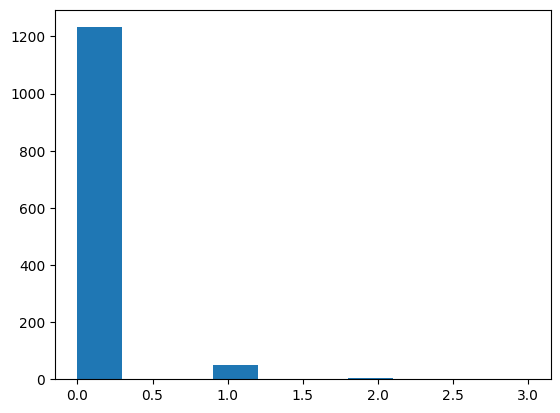

In [15]:
from matplotlib import pyplot as plt

plt.hist([len(v['FP']) for v in ret.values()])

(array([1.099e+03, 1.550e+02, 0.000e+00, 2.000e+01, 0.000e+00, 7.000e+00,
        4.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

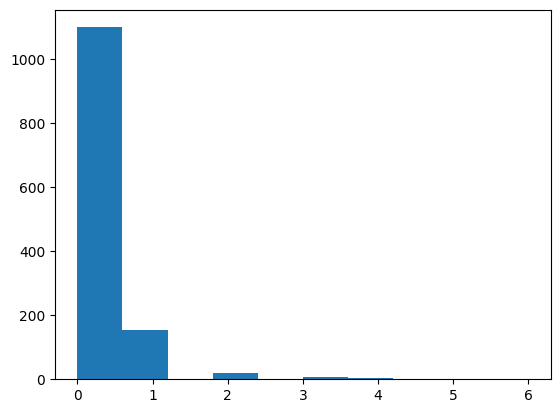

In [16]:
from matplotlib import pyplot as plt

plt.hist([len(v['FN']) for v in ret.values()])

In [17]:
import os
from typing import Tuple

import cv2
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
from IPython.display import Image
from IPython.display import display as idisplay
import logging


def viz_label(
    tomo_dir: str,
    ori_spacing: float,
    ori_shape: Tuple[int],
    ref_keypoint: list[list[float]],
    sub_keypoints: list[list[float]] | None = None,
    tag: str = "",
    ref_color: Tuple[int] = (255, 0, 0),
    sub_color: Tuple[int] = (0, 255, 0),
    draw_title: bool = False,
    include_neighbor=False,
):
    """
    Returns: RGB visualization image
    """
    Z, Y, X = [int(e) for e in ori_shape]
    r = round(1000 / ori_spacing)
    z, y, x = [round(e) for e in ref_keypoint[:3]]
    if len(ref_keypoint) == 3:
        conf = None
    else:
        conf = ref_keypoint[3]

    if z == -1:
        has_kpt = False
        assert z == y == x == -1
        z = Z // 2
    else:
        has_kpt = True
    if z > Z:
        raise ValueError(f'Invalid value of z={z} Z={Z}')
    elif z == Z:
        logger.warning('Visualization with z==Z==%d', z)
        z -= 1

    nearby_stride = max(1, round(250. / ori_spacing))
    z_before = max(z-nearby_stride, 0)
    z_after = min(z+nearby_stride, Z-1)

    vizs = []
    for slice_at_z in [z_before, z, z_after]:
        img_viz = cv2.imread(os.path.join(tomo_dir, f"slice_{slice_at_z:04d}.jpg"), cv2.IMREAD_COLOR)
        Y, X = img_viz.shape[:2]
        if draw_title:
            cv2.putText(
                heatmap_viz,
                f"{Z}x{Y}x{X}",
                (0, 120),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (255, 255, 255),
                thickness=2,
            )
    
        if sub_keypoints is not None:
            for sub_kpt in sub_keypoints:
                z2, y2, x2 = [round(e) for e in sub_kpt[:3]]
                r2 = round(max(0.0, (r**2 - (z2 - slice_at_z) ** 2)) ** 0.5)
                assert r2 >= 0
                if r2 > 0:
                    cv2.circle(img_viz, (x2, y2), radius=r2, color=sub_color, thickness=3)
    
        if has_kpt:
            r2 = round(max(0.0, (r**2 - (z - slice_at_z) ** 2)) ** 0.5)
            cv2.circle(img_viz, (x, y), radius=r2, color=ref_color, thickness=3)
            cv2.putText(
                img_viz,
                f'{conf:.2f} {(z,y,x)} {slice_at_z}' if conf is not None else f'{(z,y,x)} {slice_at_z}',
                (0, 40),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (255, 255, 255),
                thickness=2,
            )
        vizs.append(img_viz)

    final_viz = np.concatenate(vizs, axis=1)  # (H, 3*W, C)
    return final_viz


In [18]:
!rm -rf /home/dangnh36/datasets/.comp/byu/processed/pseudo_label/external/

aba2014-02-21-24


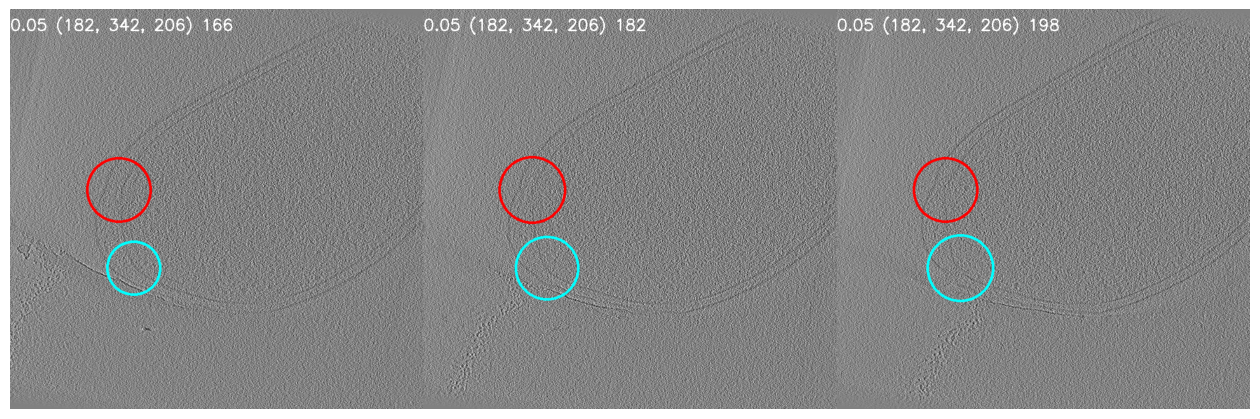

aba2014-04-10-17


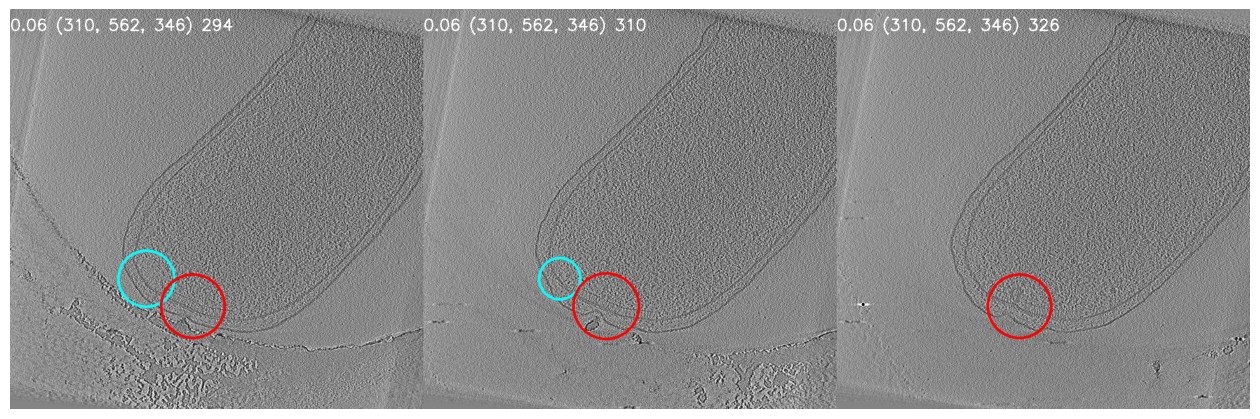

aba2014-10-15-16


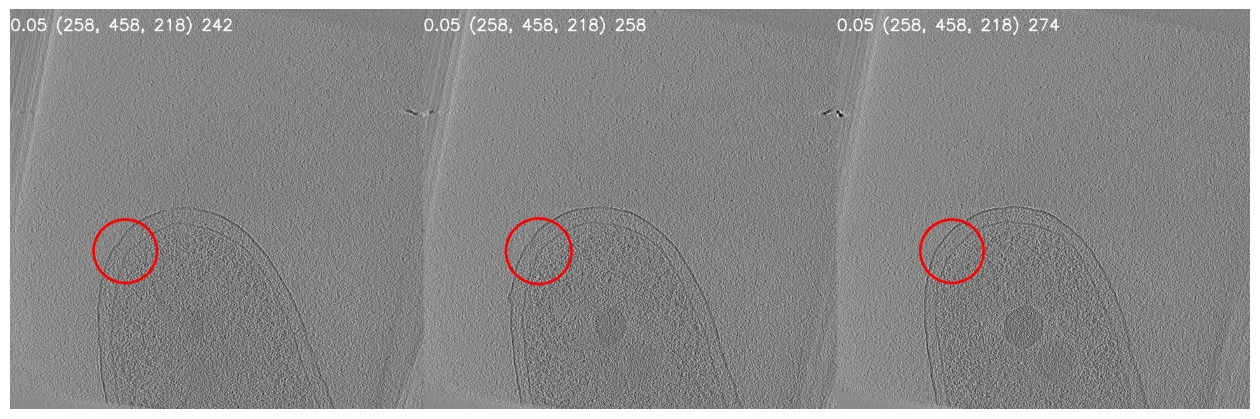

In [19]:
SAVE_DIR = '/home/dangnh36/datasets/.comp/byu/processed/pseudo_label/external/FP'
try:
    shutil.rmtree(SAVE_DIR)
except:
    pass
os.makedirs(SAVE_DIR, exist_ok=False)

########### FP ###########
count = 0
for tomo_id, v in ret.items():
    tomo_dir = f'/home/dangnh36/datasets/.comp/byu/external/tomogram/{tomo_id}'
    ref_keypoints = [[*zyx, conf] for zyx, conf in zip(v['FP'], v['FP_conf'])]
    if len(ref_keypoints) == 0:
        continue
    sub_keypoints = v['TP'] + v['FN'] + v['FP']
    vizs = []
    for ref_keypoint in ref_keypoints:
        viz = viz_label(
            tomo_dir,
            ori_spacing = v['voxel_spacing'],
            ori_shape = v['tomo_shape'],
            ref_keypoint = ref_keypoint,
            sub_keypoints = sub_keypoints,
            tag = "FP",
            ref_color = (255, 0, 0),
            sub_color = (0, 255, 255),
            draw_title = False,
            include_neighbor=False,
            )
        vizs.append(viz)
    viz = np.concatenate(vizs, axis = 0)
    
    count += 1
    if count <= 3:
        print(tomo_id)
        plt.figure(figsize=(16, 16))
        plt.imshow(viz)
        plt.axis('off')
        plt.show()
    
    save_path = os.path.join(SAVE_DIR, f"FP-{tomo_id}-{'x'.join([str(int(e)) for e in v['tomo_shape']])}-spacing{v['voxel_spacing']}.jpg")
    cv2.imwrite(save_path, cv2.cvtColor(viz, cv2.COLOR_RGB2BGR))

aba2014-02-21-27


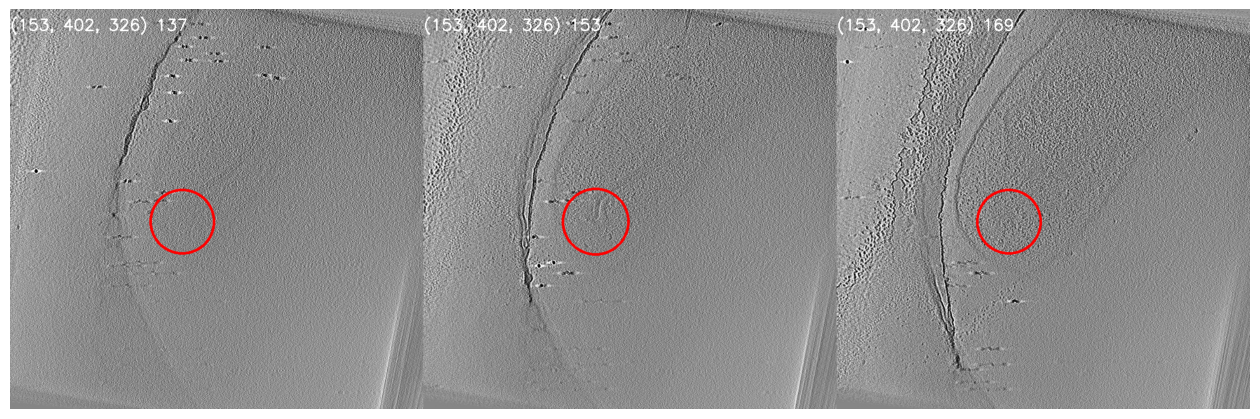

aba2014-02-21-9


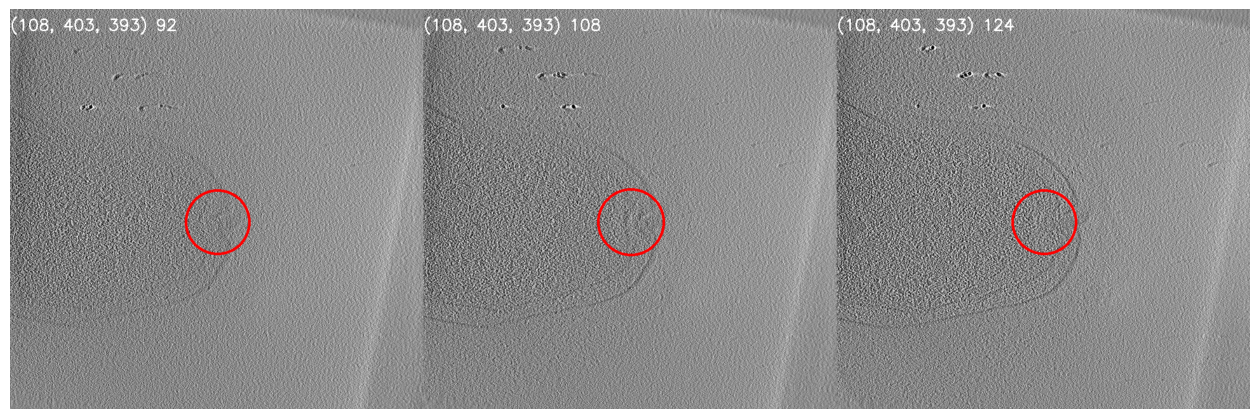

aba2014-03-04-16


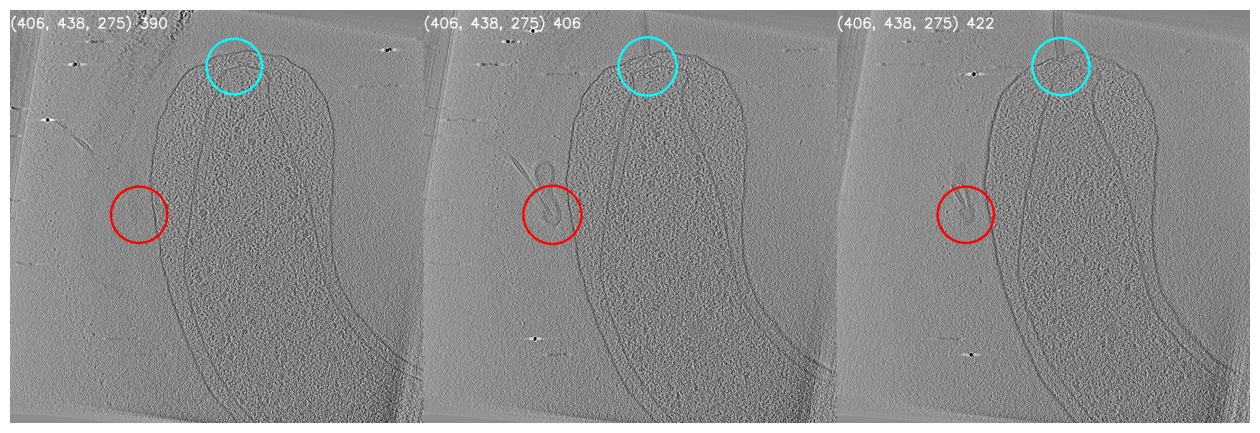

In [20]:
SAVE_DIR = '/home/dangnh36/datasets/.comp/byu/processed/pseudo_label/external/FN/'

try:
    shutil.rmtree(SAVE_DIR)
except:
    pass
os.makedirs(SAVE_DIR, exist_ok=False)

########### FN ###########
count = 0
for tomo_id, v in ret.items():
    tomo_dir = f'/home/dangnh36/datasets/.comp/byu/external/tomogram/{tomo_id}'
    ref_keypoints = v['FN']
    if len(ref_keypoints) == 0:
        continue
    sub_keypoints = v['TP'] + v['FN'] + v['FP']
    vizs = []
    for ref_keypoint in ref_keypoints:
        viz = viz_label(
            tomo_dir,
            ori_spacing = v['voxel_spacing'],
            ori_shape = v['tomo_shape'],
            ref_keypoint = ref_keypoint,
            sub_keypoints = sub_keypoints,
            tag = "FN",
            ref_color = (255, 0, 0),
            sub_color = (0, 255, 255),
            draw_title = False,
            include_neighbor=False,
            )
        vizs.append(viz)
    viz = np.concatenate(vizs, axis = 0)

    count += 1
    if count <= 3:
        print(tomo_id)
        plt.figure(figsize=(16, 16))
        plt.imshow(viz)
        plt.axis('off')
        plt.show()
    
    save_path = os.path.join(SAVE_DIR, f"FP-{tomo_id}-{'x'.join([str(int(e)) for e in v['tomo_shape']])}-spacing{v['voxel_spacing']}.jpg")
    cv2.imwrite(save_path, cv2.cvtColor(viz, cv2.COLOR_RGB2BGR))

# Create gt_external.csv

In [19]:
with open('/home/dangnh36/datasets/.comp/byu/processed/pseudo_label/external/meta.json', 'r') as f:
    meta = json.load(f)
print(len(meta))
print(list(meta.keys())[0])
print(list(meta.values())[0])

1287
aba2013-04-06-10
{'TP': [[281.5, 229.5, 445.5]], 'TP_from_gt': [[284.539375, 233.47241424989306, 436.5087872443012]], 'TP_conf': [0.61279296875], 'FN': [], 'FP': [], 'FP_conf': [], 'voxel_spacing': 16.0, 'tomo_shape': [541, 625, 647]}


In [12]:
import xml.etree.ElementTree as ET
import polars as pl


def parse_cvat_tag_annotations(xml_file_path):
    """
    Parse a CVAT annotation XML file and return a dictionary mapping filenames to tags.
    
    Args:
        xml_file_path: Path to the CVAT annotation XML file
        
    Returns:
        dict: A dictionary with filenames as keys and lists of tags as values
    """
    # Parse the XML file
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    
    # Create a dictionary to store the results
    filename_to_tags = {}
    
    # Iterate through all image elements
    for image in root.findall('.//image'):
        # Get the filename from the 'name' attribute
        filename = image.get('name')
        
        # Initialize an empty list for this filename
        tags = []
        
        # Find all tag elements for this image
        for tag in image.findall('./tag'):
            # Get the label attribute
            label = tag.get('label')
            if label:
                tags.append(label)
        
        # Add the filename and its tags to the dictionary
        filename_to_tags[filename] = tags
    
    return filename_to_tags

In [22]:
fp_anno = parse_cvat_tag_annotations("/home/dangnh36/datasets/.comp/byu/processed/pseudo_label/external/cvat.xml")
print(fp_anno)

{'FP/FP-aba2014-02-21-24-408x757x783-spacing16.0.jpg': [], 'FP/FP-aba2014-04-10-17-652x757x783-spacing16.0.jpg': ['0'], 'FP/FP-aba2014-10-15-16-652x757x783-spacing16.0.jpg': ['0'], 'FP/FP-aba2014-10-29-16-652x757x783-spacing16.0.jpg': ['0'], 'FP/FP-aba2014-10-29-20-652x757x783-spacing16.0.jpg': ['0'], 'FP/FP-aba2014-10-29-24-652x757x783-spacing16.0.jpg': ['0'], 'FP/FP-aba2015-02-23-34-652x757x783-spacing16.0.jpg': [], 'FP/FP-aba2015-02-23-61-652x757x783-spacing16.0.jpg': ['0'], 'FP/FP-aba2015-05-29-39-652x757x783-spacing16.0.jpg': ['0'], 'FP/FP-aba2015-07-29-41-652x757x783-spacing16.0.jpg': [], 'FP/FP-mba2010-08-30-4-246x288x288-spacing16.0.jpg': ['0'], 'FP/FP-mba2011-02-03-1-290x587x565-spacing16.0.jpg': ['0'], 'FP/FP-mba2011-03-02-10-276x990x990-spacing16.0.jpg': ['0'], 'FP/FP-mba2011-03-02-12-440x990x990-spacing16.0.jpg': ['0', '1', '2'], 'FP/FP-mba2011-03-02-4-290x990x990-spacing16.0.jpg': ['0', '1'], 'FP/FP-mba2011-03-02-7-325x990x990-spacing16.0.jpg': ['0', '1'], 'FP/FP-mba2011-0

In [23]:
len(fp_anno)

55

In [25]:
fp_anno = {'-'.join(os.path.basename(k)[3:].split('-')[:-2]): [int(e) for e in v] for k, v in fp_anno.items()}
fp_anno

{'aba2014-02-21-24': [],
 'aba2014-04-10-17': [0],
 'aba2014-10-15-16': [0],
 'aba2014-10-29-16': [0],
 'aba2014-10-29-20': [0],
 'aba2014-10-29-24': [0],
 'aba2015-02-23-34': [],
 'aba2015-02-23-61': [0],
 'aba2015-05-29-39': [0],
 'aba2015-07-29-41': [],
 'mba2010-08-30-4': [0],
 'mba2011-02-03-1': [0],
 'mba2011-03-02-10': [0],
 'mba2011-03-02-12': [0, 1, 2],
 'mba2011-03-02-4': [0, 1],
 'mba2011-03-02-7': [0, 1],
 'mba2011-03-24-1': [0],
 'mba2011-03-24-18': [0],
 'mba2011-07-18-10': [0],
 'mba2011-07-18-11': [0],
 'mba2011-07-30-1': [0],
 'mba2011-07-31-1': [0],
 'mba2011-08-01-15': [0],
 'mba2011-08-01-2': [0],
 'mba2011-08-01-4': [0],
 'mba2011-08-01-7': [0],
 'mba2011-08-26-20': [0],
 'mba2011-11-23-15': [0],
 'mba2012-03-09-10': [0],
 'mba2012-03-09-20': [0],
 'mba2012-03-09-26': [0],
 'mba2012-03-09-30': [0],
 'mba2012-03-09-41': [0],
 'mba2012-03-09-44': [0],
 'mba2012-03-09-62': [0],
 'mba2012-03-20-8': [0],
 'mba2012-04-24-13': [0],
 'mba2012-09-19-7': [0],
 'mba2012-09-26

In [20]:
for k in fp_anno:
    assert k in meta

In [27]:
all_rows = []
for tomo_id, tomo_meta in meta.items():
    Z, Y, X = tomo_meta['tomo_shape']
    # recalculate all keypoints here
    motor_zyxs = tomo_meta['TP'] + tomo_meta['FN'] + [tomo_meta['FP'][idx] for idx in fp_anno.get(tomo_id, [])]
    row = {
        'tomo_id': tomo_id,
        'Z': Z,
        'Y': Y,
        'X': X,
        'voxel_spacing': tomo_meta['voxel_spacing'],
        'num_motors': len(motor_zyxs),
        'motor_z': motor_zyxs[0][0],
        'motor_y': motor_zyxs[0][1],
        'motor_x': motor_zyxs[0][2],
        'motor_zyx': motor_zyxs,
    }
    all_rows.append(row)

print(len(all_rows))
ext_df = pl.DataFrame(all_rows)
ext_df

1287


shape: (1_287, 10)
┌──────────────────┬─────┬─────┬─────┬───┬─────────┬─────────┬─────────┬───────────────────────────┐
│ tomo_id          ┆ Z   ┆ Y   ┆ X   ┆ … ┆ motor_z ┆ motor_y ┆ motor_x ┆ motor_zyx                 │
│ ---              ┆ --- ┆ --- ┆ --- ┆   ┆ ---     ┆ ---     ┆ ---     ┆ ---                       │
│ str              ┆ i64 ┆ i64 ┆ i64 ┆   ┆ f64     ┆ f64     ┆ f64     ┆ list[list[f64]]           │
╞══════════════════╪═════╪═════╪═════╪═══╪═════════╪═════════╪═════════╪═══════════════════════════╡
│ aba2013-04-06-10 ┆ 541 ┆ 625 ┆ 647 ┆ … ┆ 281.5   ┆ 229.5   ┆ 445.5   ┆ [[281.5, 229.5, 445.5]]   │
│ aba2013-04-06-12 ┆ 541 ┆ 625 ┆ 647 ┆ … ┆ 281.5   ┆ 221.5   ┆ 289.5   ┆ [[281.5, 221.5, 289.5]]   │
│ aba2013-04-06-13 ┆ 541 ┆ 625 ┆ 647 ┆ … ┆ 265.5   ┆ 597.5   ┆ 281.5   ┆ [[265.5, 597.5, 281.5]]   │
│ aba2013-04-06-14 ┆ 541 ┆ 625 ┆ 647 ┆ … ┆ 249.5   ┆ 169.5   ┆ 301.5   ┆ [[249.5, 169.5, 301.5]]   │
│ aba2013-04-06-15 ┆ 541 ┆ 625 ┆ 647 ┆ … ┆ 297.5   ┆ 105.5   ┆ 497.5   ┆ [[297.5, 105.5, 497.5],   │
│                  ┆     ┆     ┆     ┆   ┆         ┆         ┆         ┆ [273.5…                   │
│ …                ┆ …   ┆ …   ┆ …   ┆ … ┆ …       ┆ …       ┆ …       ┆ …                         │
│ ycw2013-11-24-19 ┆ 800 ┆ 928 ┆ 960 ┆ … ┆ 439.0   ┆ 173.0   ┆ 419.5   ┆ [[439.0, 173.0, 419.5],   │
│                  ┆     ┆     ┆     ┆   ┆         ┆         ┆         ┆ [406.5…                   │
│ ycw2013-11-24-2  ┆ 800 ┆ 928 ┆ 960 ┆ … ┆ 429.25  ┆ 799.0   ┆ 834.5   ┆ [[429.25, 799.0, 834.5]]  │
│ ycw2013-11-24-24 ┆ 800 ┆ 928 ┆ 960 ┆ … ┆ 348.25  ┆ 332.0   ┆ 260.5   ┆ [[348.25, 332.0, 260.5],  │
│                  ┆     ┆     ┆     ┆   ┆         ┆         ┆         ┆ [328.…                    │
│ ycw2013-11-24-5  ┆ 800 ┆ 928 ┆ 960 ┆ … ┆ 396.75  ┆ 150.375 ┆ 620.5   ┆ [[396.75, 150.375,        │
│                  ┆     ┆     ┆     ┆   ┆         ┆         ┆         ┆ 620.5], [42…              │
│ ycw2017-11-30-30 ┆ 600 ┆ 928 ┆ 960 ┆ … ┆ 354.25  ┆ 227.375 ┆ 632.0   ┆ [[354.25, 227.375,        │
│                  ┆     ┆     ┆     ┆   ┆         ┆         ┆         ┆ 632.0], [35…              │
└──────────────────┴─────┴─────┴─────┴───┴─────────┴─────────┴─────────┴───────────────────────────┘

In [34]:
meta['mba2011-03-02-12'], ext_df.filter(pl.col('tomo_id') == 'mba2011-03-02-12')['motor_zyx'][0].to_list()

({'TP': [[201.5, 677.5, 517.5]],
  'TP_from_gt': [[196.53296703296704, 667.038118805941, 522.4921800650401]],
  'TP_conf': [0.29931640625],
  'FN': [],
  'FP': [[253.5, 685.5, 697.5], [201.5, 329.5, 601.5], [269.5, 729.5, 605.5]],
  'FP_conf': [0.340087890625, 0.314453125, 0.2264404296875],
  'voxel_spacing': 16.0,
  'tomo_shape': [440, 990, 990]},
 [[201.5, 677.5, 517.5],
  [253.5, 685.5, 697.5],
  [201.5, 329.5, 601.5],
  [269.5, 729.5, 605.5]])

In [35]:
meta['mba2011-11-23-15'], ext_df.filter(pl.col('tomo_id') == 'mba2011-11-23-15')['motor_zyx'][0].to_list()

({'TP': [[125.5, 393.5, 329.5]],
  'TP_from_gt': [[125.43875, 396.6256026423765, 332.1987988516575]],
  'TP_conf': [0.62060546875],
  'FN': [],
  'FP': [[153.5, 545.5, 201.5]],
  'FP_conf': [0.0540771484375],
  'voxel_spacing': 16.0,
  'tomo_shape': [259, 657, 657]},
 [[125.5, 393.5, 329.5], [153.5, 545.5, 201.5]])

In [36]:
ext_df = ext_df.with_columns(
    pl.col('motor_zyx').map_elements(lambda x: str([e for e in x.to_list() if e[0] >= 0]), return_dtype = pl.String)
)
ext_df

shape: (1_287, 10)
┌──────────────────┬─────┬─────┬─────┬───┬─────────┬─────────┬─────────┬───────────────────────────┐
│ tomo_id          ┆ Z   ┆ Y   ┆ X   ┆ … ┆ motor_z ┆ motor_y ┆ motor_x ┆ motor_zyx                 │
│ ---              ┆ --- ┆ --- ┆ --- ┆   ┆ ---     ┆ ---     ┆ ---     ┆ ---                       │
│ str              ┆ i64 ┆ i64 ┆ i64 ┆   ┆ f64     ┆ f64     ┆ f64     ┆ str                       │
╞══════════════════╪═════╪═════╪═════╪═══╪═════════╪═════════╪═════════╪═══════════════════════════╡
│ aba2013-04-06-10 ┆ 541 ┆ 625 ┆ 647 ┆ … ┆ 281.5   ┆ 229.5   ┆ 445.5   ┆ [[281.5, 229.5, 445.5]]   │
│ aba2013-04-06-12 ┆ 541 ┆ 625 ┆ 647 ┆ … ┆ 281.5   ┆ 221.5   ┆ 289.5   ┆ [[281.5, 221.5, 289.5]]   │
│ aba2013-04-06-13 ┆ 541 ┆ 625 ┆ 647 ┆ … ┆ 265.5   ┆ 597.5   ┆ 281.5   ┆ [[265.5, 597.5, 281.5]]   │
│ aba2013-04-06-14 ┆ 541 ┆ 625 ┆ 647 ┆ … ┆ 249.5   ┆ 169.5   ┆ 301.5   ┆ [[249.5, 169.5, 301.5]]   │
│ aba2013-04-06-15 ┆ 541 ┆ 625 ┆ 647 ┆ … ┆ 297.5   ┆ 105.5   ┆ 497.5   ┆ [[297.5, 105.5, 497.5],   │
│                  ┆     ┆     ┆     ┆   ┆         ┆         ┆         ┆ [273.5…                   │
│ …                ┆ …   ┆ …   ┆ …   ┆ … ┆ …       ┆ …       ┆ …       ┆ …                         │
│ ycw2013-11-24-19 ┆ 800 ┆ 928 ┆ 960 ┆ … ┆ 439.0   ┆ 173.0   ┆ 419.5   ┆ [[439.0, 173.0, 419.5],   │
│                  ┆     ┆     ┆     ┆   ┆         ┆         ┆         ┆ [406.5…                   │
│ ycw2013-11-24-2  ┆ 800 ┆ 928 ┆ 960 ┆ … ┆ 429.25  ┆ 799.0   ┆ 834.5   ┆ [[429.25, 799.0, 834.5]]  │
│ ycw2013-11-24-24 ┆ 800 ┆ 928 ┆ 960 ┆ … ┆ 348.25  ┆ 332.0   ┆ 260.5   ┆ [[348.25, 332.0, 260.5],  │
│                  ┆     ┆     ┆     ┆   ┆         ┆         ┆         ┆ [328.…                    │
│ ycw2013-11-24-5  ┆ 800 ┆ 928 ┆ 960 ┆ … ┆ 396.75  ┆ 150.375 ┆ 620.5   ┆ [[396.75, 150.375,        │
│                  ┆     ┆     ┆     ┆   ┆         ┆         ┆         ┆ 620.5], [42…              │
│ ycw2017-11-30-30 ┆ 600 ┆ 928 ┆ 960 ┆ … ┆ 354.25  ┆ 227.375 ┆ 632.0   ┆ [[354.25, 227.375,        │
│                  ┆     ┆     ┆     ┆   ┆         ┆         ┆         ┆ 632.0], [35…              │
└──────────────────┴─────┴─────┴─────┴───┴─────────┴─────────┴─────────┴───────────────────────────┘

In [48]:
ext_df['voxel_spacing'].describe()

shape: (9, 2)
┌────────────┬──────────┐
│ statistic  ┆ value    │
│ ---        ┆ ---      │
│ str        ┆ f64      │
╞════════════╪══════════╡
│ count      ┆ 1287.0   │
│ null_count ┆ 0.0      │
│ mean       ┆ 16.25483 │
│ std        ┆ 0.89762  │
│ min        ┆ 16.0     │
│ 25%        ┆ 16.0     │
│ 50%        ┆ 16.0     │
│ 75%        ┆ 16.0     │
│ max        ┆ 19.733   │
└────────────┴──────────┘

shape: (9, 2)
┌────────────┬──────────┐
│ statistic  ┆ value    │
│ ---        ┆ ---      │
│ str        ┆ f64      │
╞════════════╪══════════╡
│ count      ┆ 1287.0   │
│ null_count ┆ 0.0      │
│ mean       ┆ 1.296037 │
│ std        ┆ 0.851405 │
│ min        ┆ 1.0      │
│ 25%        ┆ 1.0      │
│ 50%        ┆ 1.0      │
│ 75%        ┆ 1.0      │
│ max        ┆ 10.0     │
└────────────┴──────────┘

(array([1.059e+03, 1.560e+02, 3.900e+01, 1.200e+01, 6.000e+00, 1.000e+01,
        1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

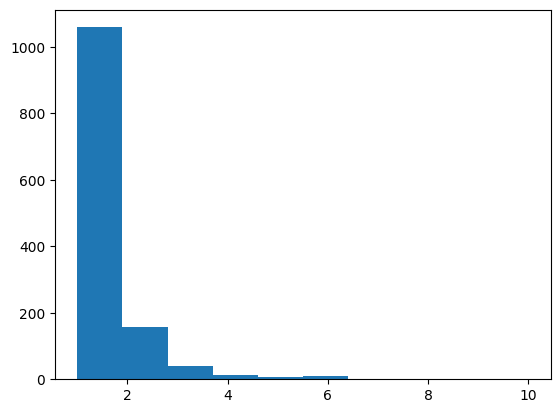

In [44]:
display(ext_df['num_motors'].describe())
plt.hist(ext_df['num_motors'])

In [37]:
ext_df.write_csv('/home/dangnh36/datasets/.comp/byu/processed/external_gt.csv')

In [39]:
ext_df.columns

['tomo_id',
 'Z',
 'Y',
 'X',
 'voxel_spacing',
 'num_motors',
 'motor_z',
 'motor_y',
 'motor_x',
 'motor_zyx']

In [40]:
train_df = pl.scan_csv('/home/dangnh36/datasets/.comp/byu/processed/gt_v2.csv').select(pl.col('tomo_id', 'Z', 'Y', 'X', 'voxel_spacing', 'num_motors', 'motor_z', 'motor_y', 'motor_x', 'motor_zyx')).collect()
train_df

shape: (648, 10)
┌─────────────┬─────┬──────┬──────┬───┬─────────┬─────────┬─────────┬─────────────────────────┐
│ tomo_id     ┆ Z   ┆ Y    ┆ X    ┆ … ┆ motor_z ┆ motor_y ┆ motor_x ┆ motor_zyx               │
│ ---         ┆ --- ┆ ---  ┆ ---  ┆   ┆ ---     ┆ ---     ┆ ---     ┆ ---                     │
│ str         ┆ i64 ┆ i64  ┆ i64  ┆   ┆ f64     ┆ f64     ┆ f64     ┆ str                     │
╞═════════════╪═════╪══════╪══════╪═══╪═════════╪═════════╪═════════╪═════════════════════════╡
│ tomo_003acc ┆ 500 ┆ 1912 ┆ 1847 ┆ … ┆ -1.0    ┆ -1.0    ┆ -1.0    ┆ []                      │
│ tomo_00e047 ┆ 300 ┆ 959  ┆ 928  ┆ … ┆ 169.0   ┆ 546.0   ┆ 603.0   ┆ [[169.0, 546.0, 603.0]] │
│ tomo_00e463 ┆ 500 ┆ 924  ┆ 956  ┆ … ┆ 235.0   ┆ 403.0   ┆ 137.0   ┆ [[235.0, 403.0, 137.0], │
│             ┆     ┆      ┆      ┆   ┆         ┆         ┆         ┆ [243.0…                 │
│ tomo_01a877 ┆ 300 ┆ 960  ┆ 928  ┆ … ┆ 147.0   ┆ 638.0   ┆ 286.0   ┆ [[147.0, 638.0, 286.0]] │
│ tomo_02862f ┆ 300 ┆ 959  ┆ 928  ┆ … ┆ 101.0   ┆ 351.0   ┆ 120.0   ┆ [[101.0, 351.0, 120.0]] │
│ …           ┆ …   ┆ …    ┆ …    ┆ … ┆ …       ┆ …       ┆ …       ┆ …                       │
│ tomo_fe050c ┆ 300 ┆ 959  ┆ 928  ┆ … ┆ 138.0   ┆ 134.0   ┆ 542.0   ┆ [[138.0, 134.0, 542.0], │
│             ┆     ┆      ┆      ┆   ┆         ┆         ┆         ┆ [143.1…                 │
│ tomo_fe85f6 ┆ 800 ┆ 928  ┆ 960  ┆ … ┆ 463.5   ┆ 903.5   ┆ 747.0   ┆ [[463.5, 903.5, 747.0]] │
│ tomo_fea6e8 ┆ 300 ┆ 960  ┆ 928  ┆ … ┆ -1.0    ┆ -1.0    ┆ -1.0    ┆ []                      │
│ tomo_ff505c ┆ 300 ┆ 959  ┆ 928  ┆ … ┆ 111.0   ┆ 816.0   ┆ 678.0   ┆ [[111.0, 816.0, 678.0]] │
│ tomo_ff7c20 ┆ 800 ┆ 928  ┆ 960  ┆ … ┆ 307.25  ┆ 493.0   ┆ 63.0    ┆ [[307.25, 493.0, 63.0]] │
└─────────────┴─────┴──────┴──────┴───┴─────────┴─────────┴─────────┴─────────────────────────┘

In [45]:
concat_df = pl.concat([train_df, ext_df])
concat_df

shape: (1_935, 10)
┌──────────────────┬─────┬──────┬──────┬───┬─────────┬─────────┬─────────┬─────────────────────────┐
│ tomo_id          ┆ Z   ┆ Y    ┆ X    ┆ … ┆ motor_z ┆ motor_y ┆ motor_x ┆ motor_zyx               │
│ ---              ┆ --- ┆ ---  ┆ ---  ┆   ┆ ---     ┆ ---     ┆ ---     ┆ ---                     │
│ str              ┆ i64 ┆ i64  ┆ i64  ┆   ┆ f64     ┆ f64     ┆ f64     ┆ str                     │
╞══════════════════╪═════╪══════╪══════╪═══╪═════════╪═════════╪═════════╪═════════════════════════╡
│ tomo_003acc      ┆ 500 ┆ 1912 ┆ 1847 ┆ … ┆ -1.0    ┆ -1.0    ┆ -1.0    ┆ []                      │
│ tomo_00e047      ┆ 300 ┆ 959  ┆ 928  ┆ … ┆ 169.0   ┆ 546.0   ┆ 603.0   ┆ [[169.0, 546.0, 603.0]] │
│ tomo_00e463      ┆ 500 ┆ 924  ┆ 956  ┆ … ┆ 235.0   ┆ 403.0   ┆ 137.0   ┆ [[235.0, 403.0, 137.0], │
│                  ┆     ┆      ┆      ┆   ┆         ┆         ┆         ┆ [243.0…                 │
│ tomo_01a877      ┆ 300 ┆ 960  ┆ 928  ┆ … ┆ 147.0   ┆ 638.0   ┆ 286.0   ┆ [[147.0, 638.0, 286.0]] │
│ tomo_02862f      ┆ 300 ┆ 959  ┆ 928  ┆ … ┆ 101.0   ┆ 351.0   ┆ 120.0   ┆ [[101.0, 351.0, 120.0]] │
│ …                ┆ …   ┆ …    ┆ …    ┆ … ┆ …       ┆ …       ┆ …       ┆ …                       │
│ ycw2013-11-24-19 ┆ 800 ┆ 928  ┆ 960  ┆ … ┆ 439.0   ┆ 173.0   ┆ 419.5   ┆ [[439.0, 173.0, 419.5], │
│                  ┆     ┆      ┆      ┆   ┆         ┆         ┆         ┆ [406.5…                 │
│ ycw2013-11-24-2  ┆ 800 ┆ 928  ┆ 960  ┆ … ┆ 429.25  ┆ 799.0   ┆ 834.5   ┆ [[429.25, 799.0,        │
│                  ┆     ┆      ┆      ┆   ┆         ┆         ┆         ┆ 834.5]]                 │
│ ycw2013-11-24-24 ┆ 800 ┆ 928  ┆ 960  ┆ … ┆ 348.25  ┆ 332.0   ┆ 260.5   ┆ [[348.25, 332.0,        │
│                  ┆     ┆      ┆      ┆   ┆         ┆         ┆         ┆ 260.5], [328.…          │
│ ycw2013-11-24-5  ┆ 800 ┆ 928  ┆ 960  ┆ … ┆ 396.75  ┆ 150.375 ┆ 620.5   ┆ [[396.75, 150.375,      │
│                  ┆     ┆      ┆      ┆   ┆         ┆         ┆         ┆ 620.5], [42…            │
│ ycw2017-11-30-30 ┆ 600 ┆ 928  ┆ 960  ┆ … ┆ 354.25  ┆ 227.375 ┆ 632.0   ┆ [[354.25, 227.375,      │
│                  ┆     ┆      ┆      ┆   ┆         ┆         ┆         ┆ 632.0], [35…            │
└──────────────────┴─────┴──────┴──────┴───┴─────────┴─────────┴─────────┴─────────────────────────┘

In [47]:
concat_df.write_csv('/home/dangnh36/datasets/.comp/byu/processed/all_gt.csv')

In [4]:
ext_df = pl.scan_csv('/home/dangnh36/datasets/.comp/byu/processed/external_gt.csv').collect()
ext_df

shape: (1_287, 10)
┌──────────────────┬─────┬─────┬─────┬───┬─────────┬─────────┬─────────┬───────────────────────────┐
│ tomo_id          ┆ Z   ┆ Y   ┆ X   ┆ … ┆ motor_z ┆ motor_y ┆ motor_x ┆ motor_zyx                 │
│ ---              ┆ --- ┆ --- ┆ --- ┆   ┆ ---     ┆ ---     ┆ ---     ┆ ---                       │
│ str              ┆ i64 ┆ i64 ┆ i64 ┆   ┆ f64     ┆ f64     ┆ f64     ┆ str                       │
╞══════════════════╪═════╪═════╪═════╪═══╪═════════╪═════════╪═════════╪═══════════════════════════╡
│ aba2013-04-06-10 ┆ 541 ┆ 625 ┆ 647 ┆ … ┆ 281.5   ┆ 229.5   ┆ 445.5   ┆ [[281.5, 229.5, 445.5]]   │
│ aba2013-04-06-12 ┆ 541 ┆ 625 ┆ 647 ┆ … ┆ 281.5   ┆ 221.5   ┆ 289.5   ┆ [[281.5, 221.5, 289.5]]   │
│ aba2013-04-06-13 ┆ 541 ┆ 625 ┆ 647 ┆ … ┆ 265.5   ┆ 597.5   ┆ 281.5   ┆ [[265.5, 597.5, 281.5]]   │
│ aba2013-04-06-14 ┆ 541 ┆ 625 ┆ 647 ┆ … ┆ 249.5   ┆ 169.5   ┆ 301.5   ┆ [[249.5, 169.5, 301.5]]   │
│ aba2013-04-06-15 ┆ 541 ┆ 625 ┆ 647 ┆ … ┆ 297.5   ┆ 105.5   ┆ 497.5   ┆ [[297.5, 105.5, 497.5],   │
│                  ┆     ┆     ┆     ┆   ┆         ┆         ┆         ┆ [273.5…                   │
│ …                ┆ …   ┆ …   ┆ …   ┆ … ┆ …       ┆ …       ┆ …       ┆ …                         │
│ ycw2013-11-24-19 ┆ 800 ┆ 928 ┆ 960 ┆ … ┆ 439.0   ┆ 173.0   ┆ 419.5   ┆ [[439.0, 173.0, 419.5],   │
│                  ┆     ┆     ┆     ┆   ┆         ┆         ┆         ┆ [406.5…                   │
│ ycw2013-11-24-2  ┆ 800 ┆ 928 ┆ 960 ┆ … ┆ 429.25  ┆ 799.0   ┆ 834.5   ┆ [[429.25, 799.0, 834.5]]  │
│ ycw2013-11-24-24 ┆ 800 ┆ 928 ┆ 960 ┆ … ┆ 348.25  ┆ 332.0   ┆ 260.5   ┆ [[348.25, 332.0, 260.5],  │
│                  ┆     ┆     ┆     ┆   ┆         ┆         ┆         ┆ [328.…                    │
│ ycw2013-11-24-5  ┆ 800 ┆ 928 ┆ 960 ┆ … ┆ 396.75  ┆ 150.375 ┆ 620.5   ┆ [[396.75, 150.375,        │
│                  ┆     ┆     ┆     ┆   ┆         ┆         ┆         ┆ 620.5], [42…              │
│ ycw2017-11-30-30 ┆ 600 ┆ 928 ┆ 960 ┆ … ┆ 354.25  ┆ 227.375 ┆ 632.0   ┆ [[354.25, 227.375,        │
│                  ┆     ┆     ┆     ┆   ┆         ┆         ┆         ┆ 632.0], [35…              │
└──────────────────┴─────┴─────┴─────┴───┴─────────┴─────────┴─────────┴───────────────────────────┘

In [5]:
ext_df['num_motors'].sum()

1668

In [7]:
ext2_df = pl.scan_csv('/home/dangnh36/datasets/.comp/byu/external/external_labels_v1.csv').collect()
ext2_df

shape: (1_616, 58)
┌────────────┬────────────┬────────────┬───────────┬───┬───────────┬───────┬───────────┬───────────┐
│ motor_z    ┆ motor_y    ┆ motor_x    ┆ tomo_id   ┆ … ┆ ori_tomo_ ┆ old_z ┆ old_y     ┆ old_x     │
│ ---        ┆ ---        ┆ ---        ┆ ---       ┆   ┆ std       ┆ ---   ┆ ---       ┆ ---       │
│ f64        ┆ f64        ┆ f64        ┆ str       ┆   ┆ ---       ┆ f64   ┆ f64       ┆ f64       │
│            ┆            ┆            ┆           ┆   ┆ f64       ┆       ┆           ┆           │
╞════════════╪════════════╪════════════╪═══════════╪═══╪═══════════╪═══════╪═══════════╪═══════════╡
│ 284.539375 ┆ 233.472414 ┆ 436.508787 ┆ aba2013-0 ┆ … ┆ 2.95239   ┆ 67.0  ┆ 191.17020 ┆ 345.32457 │
│            ┆            ┆            ┆ 4-06-10   ┆   ┆           ┆       ┆ 2         ┆ 4         │
│ 288.596875 ┆ 229.129875 ┆ 289.659153 ┆ aba2013-0 ┆ … ┆ 4.758522  ┆ 68.0  ┆ 187.61279 ┆ 229.11589 │
│            ┆            ┆            ┆ 4-06-12   ┆   ┆           ┆       ┆ 3         ┆ 8         │
│ 271.690625 ┆ 587.38939  ┆ 288.90992  ┆ aba2013-0 ┆ … ┆ 5.222191  ┆ 64.0  ┆ 481.09898 ┆ 228.52299 │
│            ┆            ┆            ┆ 4-06-13   ┆   ┆           ┆       ┆ 8         ┆ 7         │
│ 258.841875 ┆ 179.19067  ┆ 299.39918  ┆ aba2013-0 ┆ … ┆ 4.632757  ┆ 61.0  ┆ 146.70259 ┆ 236.82361 │
│            ┆            ┆            ┆ 4-06-14   ┆   ┆           ┆       ┆ 6         ┆ 7         │
│ 293.330625 ┆ 102.47247  ┆ 503.190509 ┆ aba2013-0 ┆ … ┆ 5.384742  ┆ 69.0  ┆ 83.855048 ┆ 398.09279 │
│            ┆            ┆            ┆ 4-06-15   ┆   ┆           ┆       ┆           ┆ 8         │
│ …          ┆ …          ┆ …          ┆ …         ┆ … ┆ …         ┆ …     ┆ …         ┆ …         │
│ 465.0      ┆ 285.088481 ┆ 772.757128 ┆ ycw2013-1 ┆ … ┆ 4.593496  ┆ 74.0  ┆ 157.06605 ┆ 411.90380 │
│            ┆            ┆            ┆ 1-24-5    ┆   ┆           ┆       ┆ 8         ┆ 2         │
│ 471.0      ┆ 304.854189 ┆ 805.042314 ┆ ycw2013-1 ┆ … ┆ 4.593496  ┆ 75.0  ┆ 167.97127 ┆ 429.12256 │
│            ┆            ┆            ┆ 1-24-5    ┆   ┆           ┆       ┆ 7         ┆ 8         │
│ 402.0      ┆ 118.640409 ┆ 589.807739 ┆ ycw2013-1 ┆ … ┆ 4.593496  ┆ 64.0  ┆ 65.23264  ┆ 314.33079 │
│            ┆            ┆            ┆ 1-24-5    ┆   ┆           ┆       ┆           ┆ 4         │
│ 367.0      ┆ 223.074016 ┆ 628.330137 ┆ ycw2017-1 ┆ … ┆ 3.170272  ┆ 78.0  ┆ 122.85118 ┆ 334.87607 │
│            ┆            ┆            ┆ 1-30-30   ┆   ┆           ┆       ┆ 1         ┆ 3         │
│ 367.0      ┆ 276.99229  ┆ 622.989736 ┆ ycw2017-1 ┆ … ┆ 3.170272  ┆ 78.0  ┆ 152.59919 ┆ 332.02785 │
│            ┆            ┆            ┆ 1-30-30   ┆   ┆           ┆       ┆ 4         ┆ 9         │
└────────────┴────────────┴────────────┴───────────┴───┴───────────┴───────┴───────────┴───────────┘

In [13]:
for row in ext_df.iter_rows(named = True):
    tomo_id = row['tomo_id']
    num_motors = len(eval(row['motor_zyx']))
    assert num_motors == row['num_motors']
    _tmp2 = ext2_df.filter(pl.col('tomo_id') == tomo_id)
    len2 = _tmp2.shape[0]
    assert num_motors >= len2
    if num_motors > len2:
        print(tomo_id, len2, '-->', num_motors)

aba2014-04-10-17 1 --> 2
aba2014-10-15-16 1 --> 2
aba2014-10-29-16 1 --> 2
aba2014-10-29-20 1 --> 2
aba2014-10-29-24 2 --> 3
aba2015-02-23-61 1 --> 2
aba2015-05-29-39 1 --> 2
mba2010-08-30-4 1 --> 2
mba2011-02-03-1 3 --> 4
mba2011-03-02-10 1 --> 2
mba2011-03-02-12 1 --> 4
mba2011-03-02-4 2 --> 4
mba2011-03-02-7 2 --> 4
mba2011-03-24-1 1 --> 2
mba2011-03-24-18 2 --> 3
mba2011-07-18-10 1 --> 2
mba2011-07-18-11 1 --> 2
mba2011-07-30-1 1 --> 2
mba2011-07-31-1 1 --> 2
mba2011-08-01-15 2 --> 3
mba2011-08-01-2 1 --> 2
mba2011-08-01-4 3 --> 4
mba2011-08-01-7 1 --> 2
mba2011-08-26-20 2 --> 3
mba2011-11-23-15 1 --> 2
mba2012-03-09-10 1 --> 2
mba2012-03-09-20 1 --> 2
mba2012-03-09-26 1 --> 2
mba2012-03-09-30 2 --> 3
mba2012-03-09-41 1 --> 2
mba2012-03-09-44 1 --> 2
mba2012-03-09-62 1 --> 2
mba2012-03-20-8 1 --> 2
mba2012-04-24-13 2 --> 3
mba2012-09-19-7 1 --> 2
mba2012-09-26-6 1 --> 2
mba2012-09-26-8 2 --> 3
ycw2012-09-23-28 4 --> 5
ycw2012-09-23-37 2 --> 3
ycw2012-09-23-38 2 --> 3
ycw2012-09-23-